# Skeleton Code

<hr>

### 1. 전처리

#### 1-0. 예측 레이블 정의

In [1]:
import pandas as pd
import numpy as np
path = './서울_숫자.csv' # 위치에 맞게 수정하세유
df = pd.read_csv(path)

In [2]:
df['환산_보증금_월세'] = df.apply(lambda x: x['보증금(만원)'] + x['월세(만원)']*12*20, axis='columns')
df = df.drop(['보증금(만원)', '월세(만원)'], axis=1)
df = df.astype(int) # 속도를 위해 전부 인트로 하자

In [3]:
print(df.shape)
df.head(5)

(3591649, 11)


,시군구_Encoder,동_Encoder,전월세구분,전용면적(㎡),층,구분,한국은행기준금리,종가,년도,건물나이,환산_보증금_월세
0,0,9,0,77,2,0,2,1941,2014,26,33000
1,0,9,0,79,2,0,2,1941,2014,27,34000
2,0,9,0,79,1,0,2,1941,2014,27,28000
3,0,9,0,79,2,0,2,1941,2014,27,35000
4,0,9,1,104,8,0,2,1941,2014,30,49600


In [4]:
X = df.iloc[:, :10]
Y = df.iloc[:, 10]

#### 1-1. train, test, val Split

In [5]:
from sklearn.model_selection import train_test_split
train_ratio = 0.7  # train 데이터 비율
val_ratio = 0.2  # validation 데이터 비율
test_ratio = 0.1  # test 데이터 비율

# train, validation, test 데이터 분리
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=test_ratio, shuffle=True)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=val_ratio/(train_ratio+val_ratio), shuffle=True)


#### 1-2. Scaling

In [6]:
from sklearn.preprocessing import StandardScaler

# StandardScaler를 사용하여 데이터 정규화.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) # train 기준으로 val, test를 정규화한다.
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

#### 1-3. mini batch(+ shuffle), prefetch

In [7]:
import tensorflow as tf
batch_size = 32
# 배치도 각각 섞어주고, prefetch로 미리 대기 시키자.
train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).shuffle(len(Y_train)).batch(batch_size).prefetch(1)

### 2. Modeling

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [9]:
# 모델 컴파일
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [10]:
# 모델 학습
history = model.fit(train_ds, epochs=50, validation_data=(X_val, Y_val), verbose=1)

Epoch 1/50
78568/78568 [==============================] - 77s 954us/step - loss: 231377216.0000 - mae: 9093.9795 - val_loss: 200352672.0000 - val_mae: 8439.2598
Epoch 2/50
78568/78568 [==============================] - 83s 1ms/step - loss: 184584128.0000 - mae: 7979.5073 - val_loss: 172542256.0000 - val_mae: 7720.5493
Epoch 3/50
78568/78568 [==============================] - 88s 1ms/step - loss: 164667904.0000 - mae: 7556.7124 - val_loss: 158259328.0000 - val_mae: 7442.5713
Epoch 4/50
78568/78568 [==============================] - 96s 1ms/step - loss: 153666528.0000 - mae: 7320.5054 - val_loss: 150395648.0000 - val_mae: 7214.9375
Epoch 5/50
78568/78568 [==============================] - 98s 1ms/step - loss: 146939184.0000 - mae: 7175.2915 - val_loss: 143700992.0000 - val_mae: 7106.4751
Epoch 6/50
78568/78568 [==============================] - 105s 1ms/step - loss: 140665584.0000 - mae: 7039.0542 - val_loss: 137800080.0000 - val_mae: 6955.9233
Epoch 7/50
78568/78568 [===================

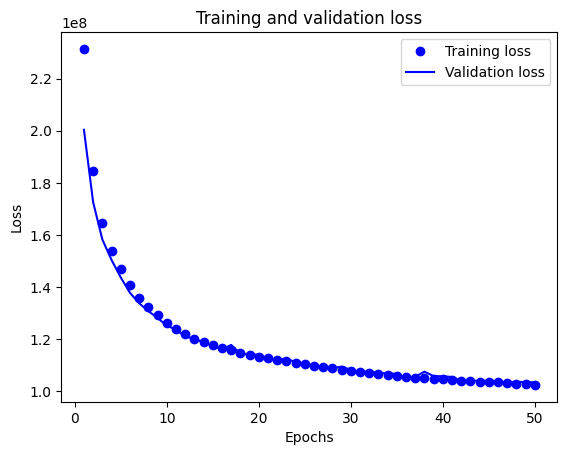

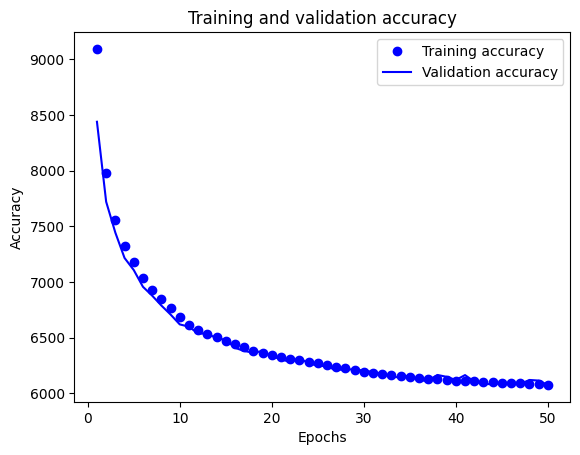

In [13]:
import matplotlib.pyplot as plt

# training 과정에서의 loss 및 accuracy 시각화
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['mae']
val_acc = history.history['val_mae']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure()

plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [80]:
Y_test_hat = model.predict(X_test).ravel().astype(int)

11224/11224 [==============================] - 7s 659us/step


In [90]:
hat_s = Y_test_hat[1000:1020]
s = Y_test[1000:1020]

<Figure size 1000x600 with 0 Axes>

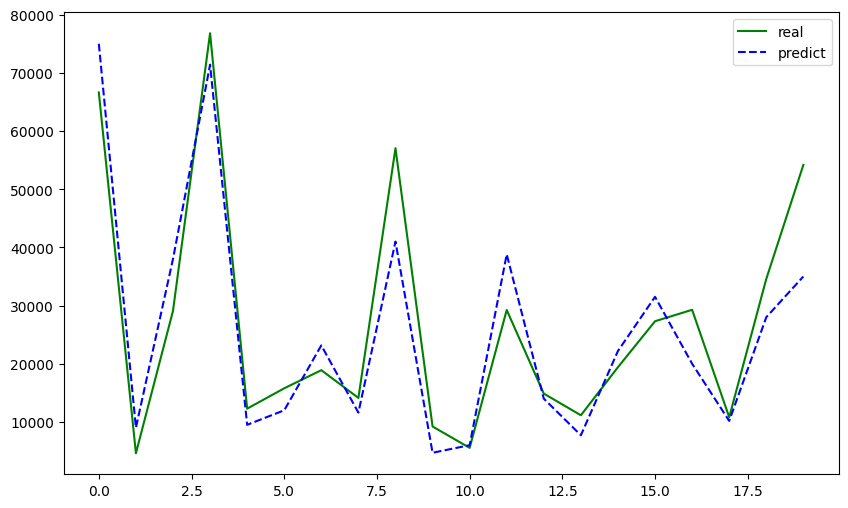

<Figure size 1000x600 with 0 Axes>

In [92]:
plt.rcParams["figure.figsize"] = (10,6)
plt.plot(np.arange(20), hat_s, '-',color = 'green', label='real')
plt.plot(np.arange(20), s, '--', color = 'blue', label='predict')
plt.legend()
plt.figure()

In [81]:
hat_s = Y_test_hat[:100]
s = Y_test[:100]

<Figure size 2000x1000 with 0 Axes>

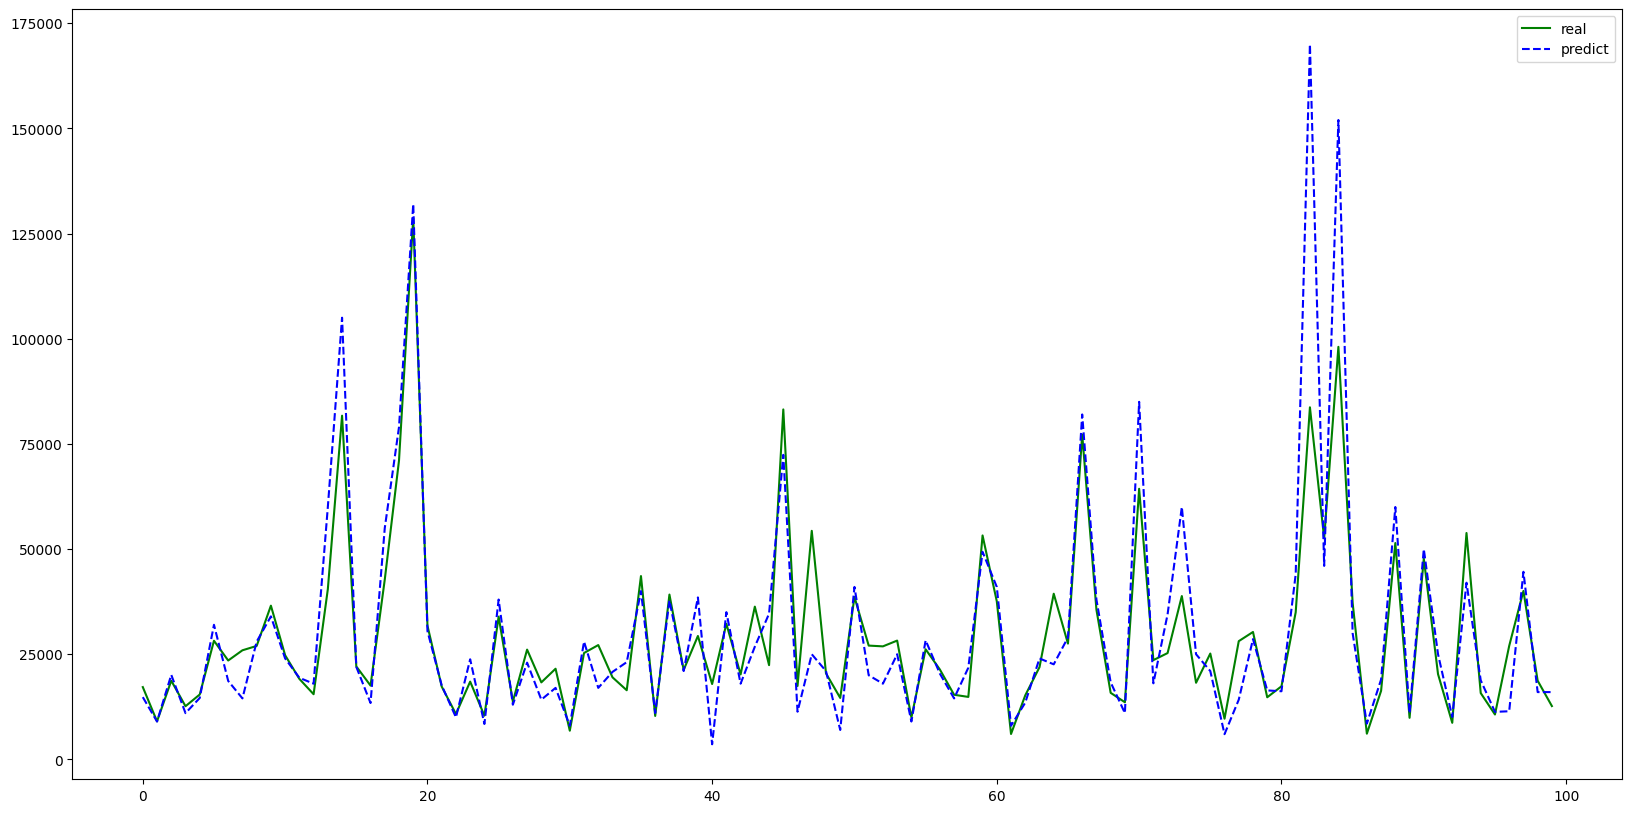

<Figure size 2000x1000 with 0 Axes>

In [86]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(np.arange(100), hat_s, '-',color = 'green', label='real')
plt.plot(np.arange(100), s, '--', color = 'blue', label='predict')
plt.legend()
plt.figure()